In [1]:
import os
import pandas as pd
import numpy as np
import copy
import sys
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)
sys.path.append("/Users/peterpriestley/hmf/repos/scripts/analysisscripts") 
import chromosomeDefinition as cd
import analyseVCF as aVCF
from scipy.stats import norm
from sklearn.neighbors import KernelDensity

In [2]:
CNV_COLUMNS = ['chrom','posStart','posEnd','copyNum','gainOrLoss','BAF','score','germlineOrSomatic','oneOrZero']

In [3]:
# LOAD BED
BED_PATH = "/Users/peterpriestley/hmf/analyses/giabTruthsets/"
BED_FILE_NAME = "NA12878_GIAB_highconf_IllFB-IllGATKHC-CG-Ion-Solid_ALLCHROM_v3.2.2_highconf.bed"
USE_BED = True
LOAD_FULL_FILE = True

### FUNCTIONS

In [4]:
def findFiles(path,suffix):
    files=[]
    for x in os.listdir(path):
        if x[-len(suffix):] == suffix:
            files.append(x)
    return files

In [5]:
def loadCNVforPatient(cnvFile,patientName):
    dfCNV = pd.read_table(cnvFile, names = CNV_COLUMNS )
    #add regions with default copy number
    last = dfCNV.iloc[0]
    for i in range(1, dfCNV.shape[0]-1):
        if last['posEnd']<>dfCNV.iloc[i]['posStart']:
            if last['chrom']==dfCNV.iloc[i]['chrom']:
                dfCNV.loc[len(dfCNV)] = [last['chrom'],last['posEnd'], dfCNV.iloc[i]['posStart']-1,2,'none','','',0,0]
            else:
                dfCNV.loc[len(dfCNV)] = [last['chrom'],last['posEnd'], cd.chromosomeLength[last['chrom']],2,'none','','',0,0]
                if dfCNV.iloc[i]['posStart']<>0:
                    dfCNV.loc[len(dfCNV)] = [dfCNV.iloc[i]['chrom'],0, dfCNV.iloc[i]['posStart'],2,'none','','',0,0]
        last = dfCNV.iloc[i]
    #fix first record
    if dfCNV.iloc[0]['posStart']<>0:
        dfCNV.loc[len(dfCNV)] = ['1',0, dfCNV.iloc[0]['posStart'],2,'none','','',0,0]
    #Additional Fields
    dfCNV['chromPos']= dfCNV['chrom'].apply(lambda x: cd.intChrom(x)) + dfCNV['posStart'] / dfCNV['chrom'].apply(lambda x: cd.chromosomeLength[str(x)])
    dfCNV['chrom'] = dfCNV['chrom'].apply(lambda x: cd.intChrom(x))
    dfCNV['cappedCopyNum'] = dfCNV['copyNum'].clip(upper=5)
    dfCNV = dfCNV.sort_values(["chrom","posStart","posEnd"]).reset_index()
    dfCNV['regionLength'] = (dfCNV['posEnd']-dfCNV['posStart'])
    dfCNV['patientName']=patientName
    return dfCNV

In [6]:
def calculateMBAFBetween(chrom,minPos,maxPos):
    dftemp = dfBAF[(dfBAF.Chromosome==chrom)&(dfBAF.Position>minPos)&(dfBAF.Position<maxPos)]
    return dftemp['mBAF'].median(),dftemp['mBAF'].count()

In [7]:
def loadBAFData(bafFile):
    df = pd.read_table(bafFile)
    return df

In [8]:
def cnvChart(dfCNV,filename,minChrom=1,maxChrom=23):
    plt.figure(figsize=[18,3])
    plt.title(filename)
    ax = plt.gca()
    ax.plot(dfCNV['chromPos'], dfCNV['copyNum'],drawstyle="steps-post")
    ax.axis([minChrom, maxChrom, 0, 6])
       

In [9]:
def cnvLabel(copyNumber):
    if copyNumber < 2:
        return 'loss'
    elif copyNumber > 2:
        return 'amplification'
    else:
        return'normal'

In [10]:
def createBAF(dfGermline):
    dfBAF = dfGermline[(dfGermline['variantType']=="SNP")&(dfGermline['normalSGT']=="0/1")&(dfGermline['normalAF']>0.4) \
                   &(dfGermline['normalAF']<0.65)&(dfGermline['normalDP']>30)&\
                   (dfGermline['normalDP']<40)][['chrom','pos','tumorAF']]
    dfBAF.columns = ['Chromosome', 'Position','BAF']
    dfBAF['Position'] = pd.to_numeric(dfBAF['Position'])
    dfBAF['mBAF']= 0.5+abs(dfBAF['BAF']-0.5)
    dfBAF['chromPos']= dfBAF['Chromosome'].apply(lambda x: cd.intChrom(x)) + dfBAF['Position'] / dfBAF['Chromosome'].apply(lambda x: cd.chromosomeLength[str(x)])
    dfBAF['Chromosome']= dfBAF['Chromosome'].apply(lambda x: cd.intChrom(x))
    return dfBAF

In [21]:
def patientIDFromFilename(filename):
    patientIDStart = filename.find("CPCT0")   #
    return filename[patientIDStart:patientIDStart+12]
    #return "GIAB12878"

In [12]:
def germlineVCFSampleNames(filename,patientID):
    return {patientID+'R':'normal',patientID+'T':'tumor'}

In [13]:
def loadVCF(path,filename,sampleNames,patientID):
    df = pd.DataFrame()
    if USE_BED:
        bed = aVCF.loadBEDFile(BED_PATH,BED_FILE_NAME)
        return pd.concat([df,aVCF.loadVariantsFromVCF(path,filename,sampleNames,patientID,True,True,bed,LOAD_FULL_FILE)])
    else:
        return pd.concat([df,aVCF.loadVariantsFromVCF(path,filename,sampleNames,patientID,True)])

In [14]:
def AFByPosPlot(pos,AF,startChartPos,endChartPos):
    plt.figure(figsize=[18,5])
    plt.scatter(pos, AF)
    plt.grid(b=True, which='both', color='0.65',linestyle='-')
    plt.axis([startChartPos, endChartPos,0, 1.0])
    plt.show()

In [15]:
def loadPON(aPath,aPONFile):
    myPON = []
    with open(aPath + aPONFile, 'r') as f:
        for line in f:
            line = line.strip('\n')
            splitLine = line.split('\t')
            myPON.append(splitLine)
    dfPON = pd.DataFrame(myPON)
    dfPON.columns = ['chrom','pos','ref','alt','PONCount']
    return dfPON

In [16]:
def findPeaks(log_dens):
    peaks = []
    troughs = []
    dens=np.exp(log_dens)
    diff = [dens[x] - dens[x-1] for x in range(1,len(dens))]
    for i in range (len(diff)-1):
        if diff[i+1] < 0 and diff[i] > 0:
            peaks.append(float(i+1)/len(dens))
        if diff[i+1] > 0 and diff[i] < 0:
            troughs.append(float(i+1)/len(dens))
    return peaks, troughs

In [17]:
def pdfChart(log_dens,maxYValue=8):
    fig, ax = plt.subplots()
    ax.plot(X_plot[:, 0], np.exp(log_dens), '-',
            label="kernel = '{0}'".format('gaussian'))
    ax.legend(loc='upper right')
    fig.set_figwidth(10)
    fig.set_figheight(5)
    ax.set_xlim(0, 1)
    ax.set_ylim(-0.02, maxYValue)
    ax.grid(b=True, which='both', color='0.65',linestyle='-')
    plt.show()

In [18]:
def calculateSomaticCNV(dfTumorCNV):
    lastSomaticCopyNum = 2
    dfTumorCNV['copyNumSomatic']= dfTumorCNV['copyNum']
    for i in range(1, dfTumorCNV.shape[0]-1):
        if dfTumorCNV.iloc[i].germlineOrSomatic=="germline":
                dfTumorCNV.ix[i,'copyNumSomatic'] = lastSomaticCopyNum
        elif dfTumorCNV.iloc[i].germlineOrSomatic=="somatic"  or dfTumorCNV.iloc[i].germlineOrSomatic=="-":  
            lastSomaticCopyNum = dfTumorCNV.ix[i,'copyNumSomatic']
    return dfTumorCNV

### LOAD PON

In [19]:
# Only needs to be run once
dfPON = loadPON("/Users/peterpriestley/hmf/analyses/PON/779filePON/","PON.tsv")

### FIND ALL FILES

In [20]:
PATH = "/Users/peterpriestley/hmf/analyses/v1.12samples/CPCT02020442/"

In [23]:
germlineVCFFilename = findFiles(PATH,"SLICED.vcf")[0]
somaticVCFFilename = findFiles(PATH,"melted.vcf")[0]
patientID = patientIDFromFilename(germlineVCFFilename)
cnvFilename = findFiles(PATH,"gz_CNVs")[0]
print "germline =",germlineVCFFilename
print "somatic =",somaticVCFFilename
print "patient =",patientID
print "CNV =",cnvFilename

germline = 170220_HMFregCPCT_FR13274369_FR13979992_CPCT02020442.annotatedSLICED.vcf
somatic = CPCT02020442R_CPCT02020442T_merged_somatics_annotated_melted.vcf
patient = CPCT02020442
CNV = CPCT02020442T_dedup.realigned.bam_CNVs


### LOAD VCFS

In [24]:
#LOAD VCFS
dfGermline = loadVCF(PATH,germlineVCFFilename,{patientID+'R':'normal',patientID+'T':'tumor'},patientID)
dfSomatic = loadVCF(PATH,somaticVCFFilename,{patientID+'T':'melted'},patientID)

reading vcf file: 170220_HMFregCPCT_FR13274369_FR13979992_CPCT02020442.annotatedSLICED.vcf
reading VCF File line: 1
reading VCF File line: 200001
Number variants loaded: 343366
reading vcf file: CPCT02020442R_CPCT02020442T_merged_somatics_annotated_melted.vcf
reading VCF File line: 1
Number variants loaded: 78936


In [25]:
# APPLY PON to SOMATICs
dfSomatic['alt'] = dfSomatic['meltedallele']
dfSomatic = pd.merge(dfSomatic,dfPON,how='left', on=['chrom','pos','ref','alt'])
dfSomatic['PONCount'].fillna(0, inplace=True)
dfSomatic['inPON'] = pd.to_numeric(dfSomatic.PONCount,errors=coerce)>4

### Load BAF and CNV and calculate median BAF per segment

In [26]:
dfBAF = createBAF(dfGermline)

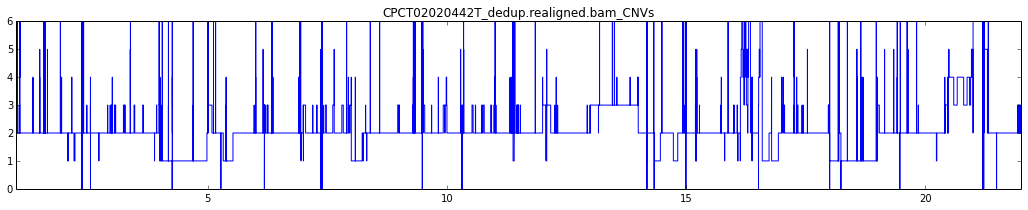

In [27]:
dfCNV = loadCNVforPatient(PATH+cnvFilename,patientID)
dfCNV['mBAF'], dfCNV['mBAFCount'] = np.vectorize(calculateMBAFBetween)(dfCNV['chrom'], dfCNV['posStart'],dfCNV['posEnd'])
cnvChart(dfCNV,cnvFilename,1,22)

### TUMOR PURITY

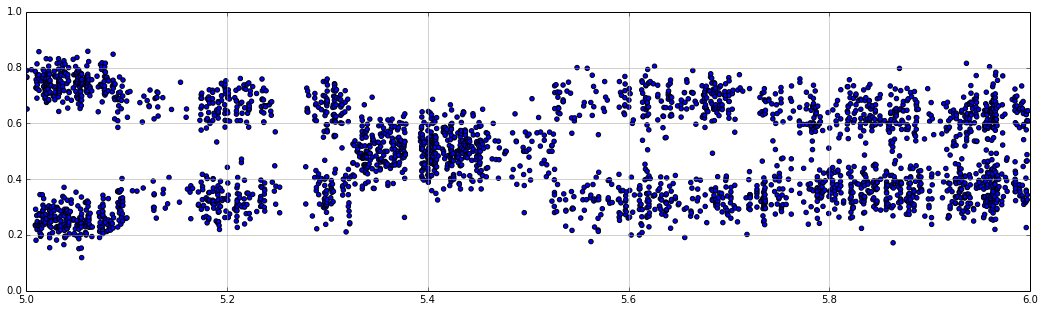

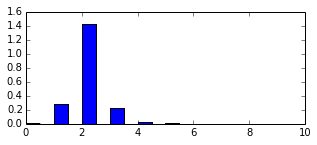

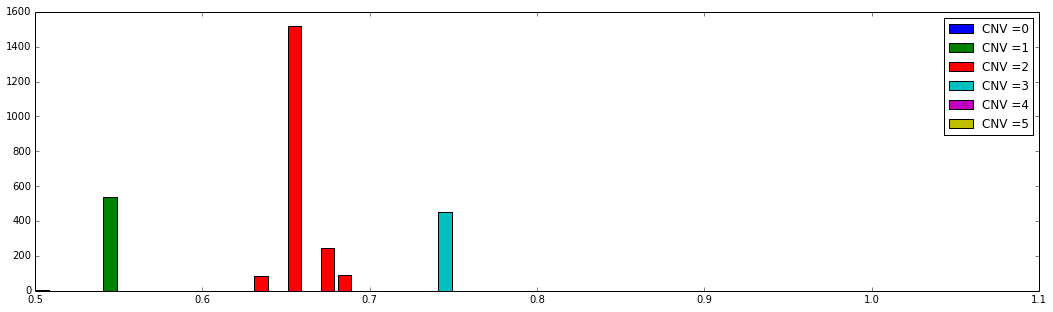

In [177]:
c, fractionMin, fractionMax = 5,0,1
dfSom = dfBAF[(dfBAF.chromPos>c+fractionMin)&(dfBAF.chromPos<c+fractionMax)]
plt.figure(figsize=[18,5])
plt.scatter(dfSom.chromPos, dfSom.BAF)
plt.grid(b=True, which='both', color='0.65',linestyle='-')
plt.axis([c+fractionMin, c+fractionMax,0, 1.0])
plt.show()
# CNV according to freeC
plt.figure(figsize=[5,2])
plt.hist(dfCNV['copyNum'].values,cumulative=False, normed=True, bins=20,range=(0,10),weights=dfCNV['regionLength'].values)
plt.show()
# should only use regions with mbaf > x
dftemp = dfCNV[(dfCNV.mBAF>=0.0)&(dfCNV.mBAF<=1.0)&(dfCNV.mBAFCount>20)&(dfCNV.chromPos<=c+fractionMax)&(dfCNV.chromPos>=c+fractionMin)]
plt.figure(figsize=[18,5])
for CNV in range(0,6):
    plt.hist(dftemp[(dftemp.copyNum==CNV)]['mBAF'].values,cumulative=False, normed=False, bins=50,range=(0.5,1.0),weights=dftemp[(dftemp.copyNum==CNV)]['mBAFCount'].values,stacked = True,rwidth=0.8,label='CNV ='+str(CNV))
    plt.legend()
plt.show()

In [178]:
dfCNV[(dfCNV.chrom==5)&(dfCNV.mBAFCount>=0)&(dfCNV.copyNum>=1)&(dfCNV.mBAF>=0.061)&(dfCNV.mBAF<=10.63)]

,index,chrom,posStart,posEnd,copyNum,gainOrLoss,BAF,score,germlineOrSomatic,oneOrZero,chromPos,cappedCopyNum,regionLength,patientName,mBAF,mBAFCount
195,124,5,0,471000,3,gain,NaN,NaN,NaN,NaN,5.000000,3,471000,CPCT02020442,0.765531,4
197,126,5,569000,999000,3,gain,NaN,NaN,NaN,NaN,5.003145,3,430000,CPCT02020442,0.792453,1
199,128,5,1296000,15752000,3,gain,NaN,NaN,NaN,NaN,5.007164,3,14456000,CPCT02020442,0.747706,450
200,602,5,15752000,21477999,2,none,,,0.0,0.0,5.087068,2,5725999,CPCT02020442,0.689488,62
205,604,5,21573000,29423999,2,none,,,0.0,0.0,5.119244,2,7850999,CPCT02020442,0.681818,31
207,605,5,29434000,49409999,2,none,,,0.0,0.0,5.162695,2,19975999,CPCT02020442,0.674157,247
209,606,5,49441000,58405999,2,none,,,0.0,0.0,5.273283,2,8964999,CPCT02020442,0.655556,151
210,134,5,58406000,69185000,1,loss,NaN,NaN,NaN,NaN,5.322836,1,10779000,CPCT02020442,0.540492,188
216,140,5,70530000,95131000,1,loss,NaN,NaN,NaN,NaN,5.389851,1,24601000,CPCT02020442,0.542857,351
217,607,5,95131000,175344999,2,none,,,0.0,0.0,5.525832,2,80213999,CPCT02020442,0.652705,1368


### SOMATIC AF

In [133]:
#dfSomatic[(dfSomatic.inPON==False)&(dfSomatic.consensus==True)&((dfSomatic.annWorstImpact=='MODERATE')|(dfSomatic.annWorstImpact=='HIGH'))]

In [134]:
#pd.pivot_table(dfSomatic, values='pos', index=['consensus','patientName','variantType'], columns=['inPON'], aggfunc='count',margins=False).fillna("")

In [135]:
#pd.pivot_table(dfSomatic[(dfSomatic.variantType == 'SNP')&(dfSomatic.consensus == True)&(dfSomatic.inPON == False)], values='pos', index=['ref'], columns=['meltedallele'], aggfunc='count',margins=True).fillna("")

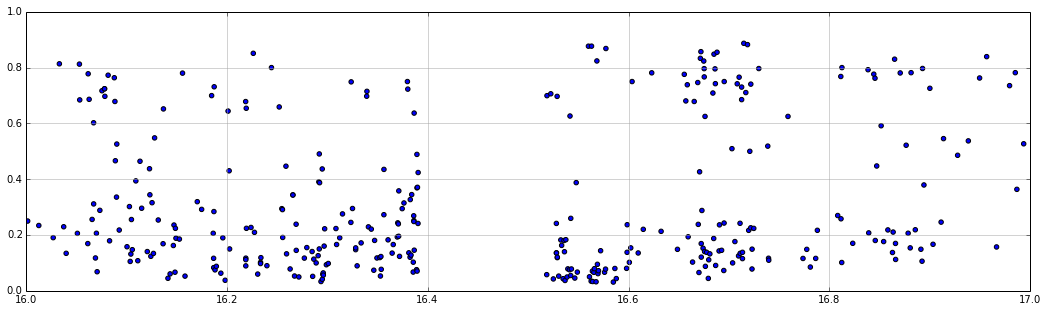

In [168]:
c,fractionMin,fractionMax = 1,0,22
dfSom = dfSomatic[(dfSomatic['variantType']=="SNP")&(dfSomatic['inPON']==False)&(dfSomatic['consensus']==True)&(dfSomatic.chromFrac>c+fractionMin)&(dfSomatic.chromFrac<c+fractionMax)]
AFByPosPlot(dfSom.chromFrac, dfSom.meltedAF,c+fractionMin, c+fractionMax)

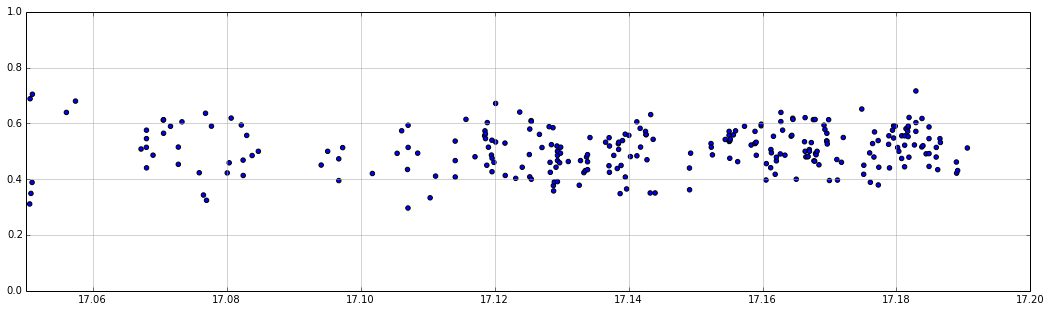

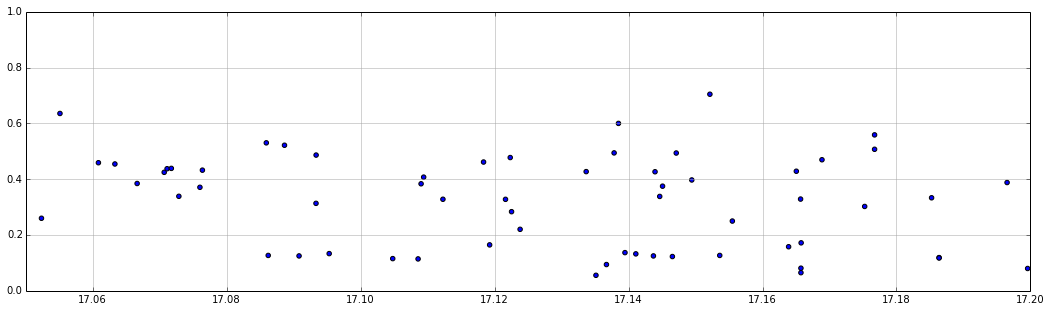

,chrom,posStart,copyNum,chromPos,regionLength,mBAF,mBAFCount


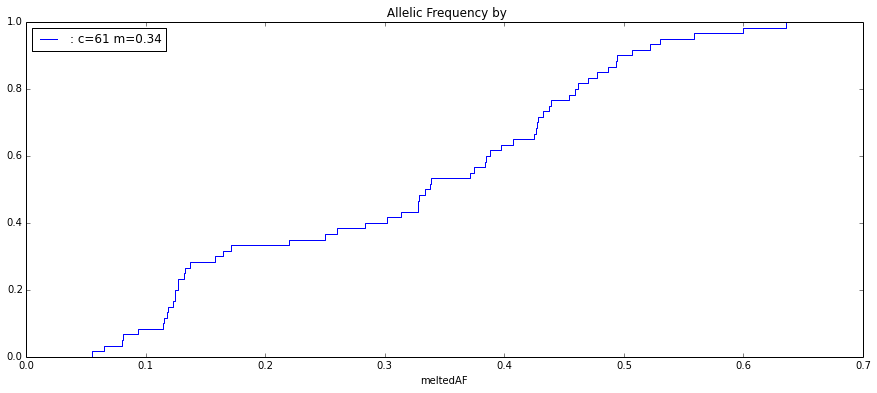

In [176]:
c,fractionMin,fractionMax = 17,0.05,0.2
dfTemp = dfBAF[(dfBAF.chromPos>c+fractionMin)&(dfBAF.chromPos<c+fractionMax)]
AFByPosPlot(dfTemp.chromPos, dfTemp.BAF,c+fractionMin, c+fractionMax)
dfSom = dfSomatic[(dfSomatic['variantType']=="SNP")&(dfSomatic['inPON']==False)&(dfSomatic['consensus']==True)&(dfSomatic.chromFrac>c+fractionMin)&(dfSomatic.chromFrac<c+fractionMax)]
AFByPosPlot(dfSom.chromFrac, dfSom.meltedAF,c+fractionMin, c+fractionMax)

#CDF
ser = dfSom.meltedAF.sort_values()
cum_dist = np.linspace(0.,1.,len(ser))
ser_cdf = pd.Series(cum_dist, index=ser,name=": c="+str(ser.count())+" m="+str(round(ser.median(),2)))
ser_cdf.plot(drawstyle='steps',legend=True,title=" Allelic Frequency by ",figsize=[15,6],xlim=[0.0,0.7])

#mbaf
dfCNV[(dfCNV.chromPos>c+fractionMin)&(dfCNV.chromPos<c+fractionMax)&(dfCNV.mBAFCount>500)][['chrom','posStart','copyNum','chromPos','regionLength','mBAF','mBAFCount']]

### PDF peak finder

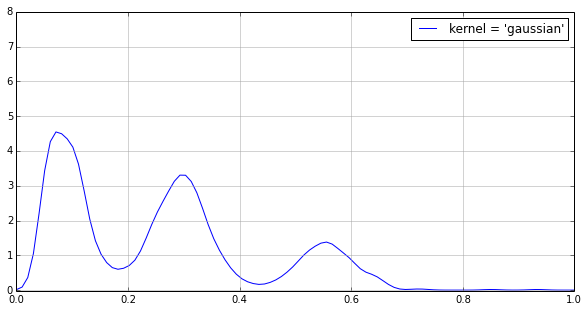

([0.07, 0.29, 0.55, 0.71, 0.84, 0.92], [0.18, 0.43, 0.69, 0.78, 0.88])

In [163]:
X = dfSom.meltedAF.sort_values()[:, np.newaxis]
X_plot = np.linspace(0,1,100)[:, np.newaxis]
kde = KernelDensity(kernel='gaussian', bandwidth=0.015).fit(X)
log_dens = kde.score_samples(X_plot)
pdfChart(log_dens)
findPeaks(log_dens)

### SV ANALYSIS

In [72]:
svVCFFilename = findFiles(PATH,"somaticSV.vcf")[0]
print "SV =",svVCFFilename
print "patient =",patientID

SV = somaticSV.vcf
patient = GIAB12878


In [74]:
dfSV = loadVCF(PATH,svVCFFilename,{patientID+'T':'tumor'},patientID)

reading vcf file: somaticSV.vcf
reading VCF File line: 1
Number variants loaded: 37


In [114]:
pd.pivot_table(dfSV[(dfSV.variantSubType<>"IGN")&(dfSV.tumorAF>=0.05)], values='id', index=['variantSubType'], columns=['variantType'], aggfunc='count').fillna("")

variantType,SV
variantSubType,
BND,12
DEL,4
DUP,1


In [76]:
def findMatchingBNDChromPos(df):
    # can 
    df['BNDMatchPos'] = ""
    for i in range(0,df.shape[0]):
        if df.iloc[i]['variantSubType'] == "BND":
            tmp = df.iloc[i]['tumorallele'].find("]")
            if tmp >= 0:
                df.iloc[i,df.columns.get_loc('BNDMatchPos')] = df.iloc[i]['tumorallele'][tmp+1:df.iloc[i]['tumorallele'].find("]",tmp+1)]
    return df

In [77]:
dfSV = findMatchingBNDChromPos(dfSV)

In [115]:
dfSV[(dfSV.variantSubType<>"ADEL")&(dfSV.tumorAF>=0.1)][['chrom','pos','chromFrac','variantSubType','bedRegion','BNDMatchPos','tumorallele','tumorAF','tumorDP','tumorSGT','tumorSVLenMin','tumorSVLenMax','tumorSVStartMin','tumorSVStartMax']]

,chrom,pos,chromFrac,variantSubType,bedRegion,BNDMatchPos,tumorallele,tumorAF,tumorDP,tumorSGT,tumorSVLenMin,tumorSVLenMax,tumorSVStartMin,tumorSVStartMax
13,7,45775809,7.287647,DEL,,,T,0.324074,1,"73,",304,322,45775809,45775827
18,10,54712385,10.403678,BND,Default,,C[Y:14478718[,0.117117,1,"98,",-235,234,54712151,54712620
27,14,106103327,14.988391,DEL,,,<DEL>,0.108434,1,"74,",94904,96221,106103080,106103575
36,Y,14478718,24.243858,BND,,10:54712385,]10:54712385]T,0.117117,1,"98,",-255,254,14478464,14478973


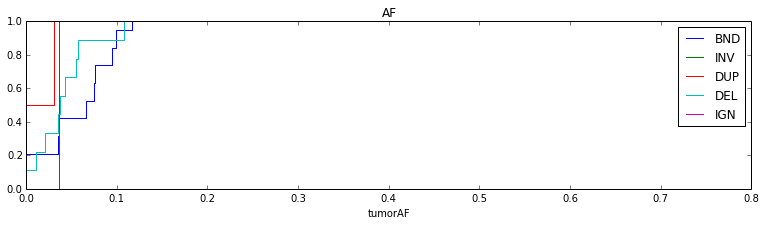

In [81]:
for variantSubType in dfSV.variantSubType.unique():
    ser = dfSV[(dfSV.variantSubType == variantSubType)]["tumorAF"].sort_values()
    cum_dist = np.linspace(0.,1.,len(ser))
    ser_cdf = pd.Series(cum_dist, index=ser,name=variantSubType)
    ser_cdf.plot(drawstyle='steps',legend=True,title="AF",figsize=[13,3],xlim=[0.0,0.8],ylim=[0.0,1.0])